In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gpplot
import plotnine as gg
import sglearn
import shap
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from scipy import stats
from sklearn.metrics import make_scorer

from datasets import behan_data, aguirre_data
from core import (add_xy_line,
                  setup_plots,
                  lollipop_plot,
                  summary_legacy)

In [2]:
setup_plots()

In [3]:
behan_data.load_data()
aguirre_data.load_data()

merged_activity = (behan_data.get_sg_df(include_group=True, include_activity=True)
                   .rename({'sgRNA Activity': 'Behan Activity'}, axis=1)
                   .merge(aguirre_data.get_sg_df(include_group=True, include_activity=True)
                          .rename({'sgRNA Activity': 'Aguirre Activity'}, axis=1),
                          how='inner', on=['sgRNA Sequence', 'sgRNA Context Sequence',
                                           'PAM Sequence', 'sgRNA Target']))
merged_activity['Behan Activity'] = ((merged_activity['Behan Activity'] - merged_activity['Behan Activity'].mean())/
                                     merged_activity['Behan Activity'].std())
merged_activity['Aguirre Activity'] = ((merged_activity['Aguirre Activity'] - merged_activity['Aguirre Activity'].mean())/
                                       merged_activity['Aguirre Activity'].std())
merged_activity['Activity Difference'] = merged_activity['Aguirre Activity'] - merged_activity['Behan Activity']

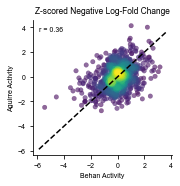

In [4]:
plt.subplots(figsize=(2.5, 2.5))
gpplot.point_densityplot(merged_activity, x='Behan Activity',
                         y='Aguirre Activity', s=20)
gpplot.add_correlation(merged_activity, x='Behan Activity',
                       y='Aguirre Activity')
add_xy_line()
sns.despine()
plt.title('Z-scored Negative Log-Fold Change')
gpplot.savefig('../figures/aguirre_behan_comparison.pdf', dpi=300)


In [5]:
def get_pearson_correlation(x, y):
    return stats.pearsonr(x, y)[0]

pearson_scorer = make_scorer(get_pearson_correlation)

X = sglearn.featurize_guides(merged_activity['sgRNA Context Sequence'])
y = merged_activity['Activity Difference']
cv_score = cross_val_score(LGBMRegressor(random_state=7), X, y, cv=5, n_jobs=5,
                           scoring=pearson_scorer)
print(cv_score)
print(cv_score.mean())

100%|██████████| 876/876 [00:02<00:00, 406.92it/s]


[0.36507757 0.30314877 0.36707273 0.29292499 0.37089176]
0.3398231636386882


Saving 1.2 x 2 in image.
Filename: ../figures/aguirre_behan_difference_cv_performance.pdf


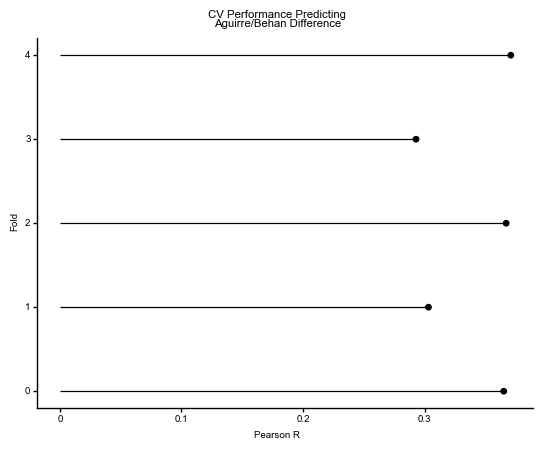

<ggplot: (8764499815747)>

In [6]:
cv_df = pd.DataFrame({'fold': list(range(0, 5)),
                      'pearson_r': cv_score})
g = lollipop_plot(cv_df, cat='fold', val='pearson_r',
                  val_label='Pearson R', cat_label='Fold')
g = (g +
     gg.ggtitle('CV Performance Predicting\nAguirre/Behan Difference'))
g.save('../figures/aguirre_behan_difference_cv_performance.pdf', width=1.2, height=2)
g


In [7]:
model = LGBMRegressor(random_state=7, n_jobs=8)
model.fit(X, y)

LGBMRegressor(n_jobs=8, random_state=7)

In [8]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

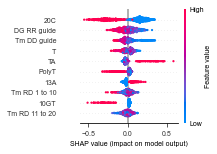

In [66]:
summary_legacy(shap_values, X, show=False, plot_size=(2.2, 2.1),
               point_size=5, text_size=None, color_bar_shrink=1,
               legend_aspect=30, max_display=10)
gpplot.savefig('../figures/agguire_behan_diff_shap.pdf', dpi=300)

In [12]:
merged_activity_features = (merged_activity
                            .merge(X.reset_index()
                                   .rename({0: 'sgRNA Context Sequence'}, axis=1),
                                   how='inner',
                                   on='sgRNA Context Sequence'))
merged_activity_features['neg Behan Activity'] = -merged_activity_features['Behan Activity']
merged_activity_features['neg Aguirre Activity'] = -merged_activity_features['Aguirre Activity']


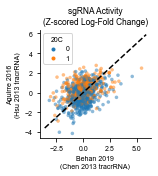

In [29]:
plt.subplots(figsize=(2, 2))
sns.scatterplot(data=merged_activity_features, x='neg Behan Activity',
                y='neg Aguirre Activity', hue='20C', alpha=0.5, s=50,
                marker='.', palette='tab10',
                linewidth=0)
add_xy_line()
sns.despine()
plt.title('sgRNA Activity\n(Z-scored Log-Fold Change)')
plt.xlabel('Behan 2019\n(Chen 2013 tracrRNA)')
plt.ylabel('Aguirre 2016\n(Hsu 2013 tracrRNA)')
plt.legend(markerscale=0.5, title='20C')
gpplot.savefig('../figures/aguirre_behan_comparison_20C.pdf', dpi=300)

In [45]:
merged_activity_features['neg Activity Difference'] = -merged_activity_features['Activity Difference']
merged_activity_features['NT in 20th sgRNA Position'] = pd.Categorical(merged_activity_features['sgRNA Sequence'].str[-1],
                                                                       categories=['A', 'C', 'G', 'T'])
nt_end_count = (merged_activity_features['NT in 20th sgRNA Position'].value_counts()
                .reset_index(name='total NT20')
                .rename({'index': 'NT in 20th sgRNA Position'}, axis=1))
merged_activity_features = merged_activity_features.merge(nt_end_count)
merged_activity_features['NT in 20th sgRNA Position'] = (merged_activity_features['NT in 20th sgRNA Position'].astype('str') +
                                                         '\n(n=' + merged_activity_features['total NT20'].astype(str) + ')')

In [52]:
nt_end_count

,NT in 20th sgRNA Position,total NT20
0,C,349
1,A,219
2,G,217
3,T,91


In [53]:
merged_activity_features['NT in 20th sgRNA Position'] = pd.Categorical(merged_activity_features['NT in 20th sgRNA Position'],
                                                                       categories=['A\n(n=219)', 'C\n(n=349)',
                                                                                   'G\n(n=217)', 'T\n(n=91)'])

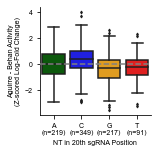

In [56]:
plt.subplots(figsize=(2, 2))
sns.boxplot(data=merged_activity_features,
            x='NT in 20th sgRNA Position',
            y='neg Activity Difference',
            fliersize=2,
            palette=['darkgreen', 'blue', 'orange', 'red'])
sns.despine()
plt.ylabel('Aguirre - Behan Activity\n(Z-scored Log-Fold Change)')
plt.axhline(y=0, color='grey', linestyle='dashed',
            zorder=10)
gpplot.savefig('../figures/Augirre_Behan_perNT_diff.pdf')